# Cuaderno de soporte para IL-CLDM
Este cuaderno concentra los comandos auxiliares que usamos para entrenar y diagnosticar el modelo de difusión latente condicionado (IL-CLDM).
- **Entrenamiento**: controla la ejecución del script principal y de cada etapa (AAE, codificador de latentes y difusor).
- **Diagnóstico**: agrupa rutinas de inspección para verificar datos, métricas y distribuciones latentes.
> Recomendación: revisa/ajusta `config.py` antes de ejecutar cualquier celda y avanza en orden según la sección que necesites.

## 1. Ejecución y entrenamiento principal
Las celdas siguientes lanzan el entrenamiento desde el notebook. Ejecuta solo las que necesites:
1. `!python main.py` corre el flujo completo desde la terminal (entrena AAE, codifica latentes y ajusta el LDM).
2. `main.train_AAE()` entrena únicamente el autoencoder adversario.
3. `main.encoding()` genera/actualiza los latentes SPECT tras entrenar el AAE.
4. `main.train_LDM()` entrena el modelo de difusión condicionado usando los latentes generados.

In [1]:
# Configura variables de entorno compartidas para las ejecuciones posteriores.
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
# Ejecuta la tubería completa (AAE + codificación + LDM) desde la línea de comandos.
!python main.py

In [ ]:
# Permite invocar funciones específicas del pipeline directamente desde Python.
import main

In [ ]:
# Entrena solo la primera etapa (AAE) sin necesidad de correr todo `main.py`.
main.train_AAE()

In [ ]:
# Genera/actualiza los latentes SPECT una vez ajustado el AAE.
main.encoding()

In [ ]:
# Empieza el entrenamiento del modelo de difusión condicionado usando los latentes almacenados.
main.train_LDM()

## 2. Evaluación cuantitativa del AAE en SPECT
Usa estas celdas para comparar reconstrucciones con los datos reales mediante PSNR/SSIM y ejecutar `aae_eval.py` cuando necesites verificar la convergencia de la primera etapa antes de continuar.

In [ ]:
import os, nibabel as nib, numpy as np, torch
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import config
from model import AAE
from utils import load_checkpoint
from dataset import center_crop

device = torch.device(config.device)
out_dir = os.path.join("result", str(config.exp), "aae_recon_test")
os.makedirs(out_dir, exist_ok=True)

latent_dir = config.latent_Abeta
sample_id = os.listdir(latent_dir)[0]  # o elige uno
latent_path = os.path.join(latent_dir, sample_id)

lat = nib.load(latent_path).get_fdata().astype(np.float32)
x_lat = torch.tensor(lat[None,None,...], device=device)
aae = AAE().to(device)
opt = torch.optim.Adam(aae.parameters(), lr=config.learning_rate)
load_checkpoint(config.CHECKPOINT_AAE, aae, opt, config.learning_rate)
aae.eval()

with torch.no_grad():
    recon = aae.decoder(x_lat)
recon = torch.clamp(recon, 0, 1).cpu().numpy().squeeze().astype(np.float32)

orig_id = os.path.splitext(sample_id)[0]
orig_path = os.path.join(config.whole_Abeta, orig_id + ".nii")
if not os.path.exists(orig_path):
    orig_path = orig_path + "gz"  # si es .nii.gz
orig_img = nib.load(orig_path)
orig = center_crop(orig_img.get_fdata().astype(np.float32), config.crop_size)
vmin, vmax = orig.min(), orig.max()
orig = np.zeros_like(orig) if vmax - vmin < 1e-8 else (orig - vmin)/(vmax - vmin)
rng = max(orig.max() - orig.min(), 1e-8)
print("PSNR", psnr(orig, recon, data_range=rng), "SSIM", ssim(orig, recon, data_range=rng))

nib.save(nib.Nifti1Image(recon, orig_img.affine),
         os.path.join(out_dir, f"{orig_id}_decoder_only.nii.gz"))

In [ ]:
import numpy as np, nibabel as nib, csv, torch
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import config
from dataset import resolve_nifti, center_crop  # usa center_crop
from model import AAE

device = torch.device(config.device)
model = AAE().to(device)
opt = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
ckpt = torch.load(config.CHECKPOINT_AAE, map_location=device)
model.load_state_dict(ckpt["state_dict"])
model.eval()

ids = [i.strip() for i in open(config.test) if i.strip()]
psnr_sum = ssim_sum = 0

with open("result/exp_1/aae_recon_test.csv", "w", newline="") as f:
    writer = csv.writer(f); writer.writerow(["ID","PSNR","SSIM"])
    for bid in ids:
        path = resolve_nifti(config.whole_Abeta, bid)
        img = nib.load(path)
        data = img.get_fdata().astype(np.float32)
        data = center_crop(data, config.crop_size)
        vmin, vmax = data.min(), data.max()
        data = np.zeros_like(data) if vmax - vmin < 1e-8 else (data - vmin)/(vmax - vmin)

        x = torch.tensor(data[None,None,...], device=device)
        with torch.no_grad():
            recon = model(x)
        recon = torch.clamp(recon, 0, 1).cpu().numpy().squeeze().astype(np.float32)

        # Asegúrate de que coinciden las formas
        if recon.shape != data.shape:
            print(f"{bid} shapes mismatch: data {data.shape}, recon {recon.shape}")
            continue

        rng = max(data.max() - data.min(), 1e-8)
        ps = psnr(data, recon, data_range=rng)
        ss = ssim(data, recon, data_range=rng)
        writer.writerow([bid, ps, ss])
        psnr_sum += ps; ssim_sum += ss

print("Promedio PSNR", psnr_sum/len(ids), "SSIM", ssim_sum/len(ids))

In [ ]:
import pandas as pd

aae_results = pd.read_csv("/workspace/projects/T1-SPECT-translation/IL-CLDM/result/exp_1/aae_recon_test/aae_metrics.csv")
aae_results.head()

In [ ]:
print(aae_results["PSNR"].mean(), aae_results["PSNR"].std(), aae_results["SSIM"].mean(), aae_results["SSIM"].std())

In [ ]:
!python aae_eval.py

In [ ]:
import os, nibabel as nib, numpy as np, torch
gen_path = "/workspace/projects/T1-SPECT-translation/IL-CLDM/data/latent_SPECT"
files = os.listdir(gen_path)

for file in files:
    #getting the shape of each file
    latent = nib.load(os.path.join(gen_path, file)).get_fdata()
    if latent.shape != (40, 48, 40):
        print(f"File: {file}, Shape: {latent.shape}")

## 3. Exploración de la representación latente de MRI
Permite inspeccionar los archivos latentes generados por el encoder para confirmar dimensiones (`config.latent_shape`) y rangos antes de alimentar el difusor.

In [ ]:
import os, nibabel as nib, torch
from dataset import resolve_nifti, center_crop, z_score_norm
from model import UNet
import config
import numpy as np

device = torch.device(config.device)

# Carga el UNet con el image_size correcto
unet = UNet(in_channel=2, out_channel=1, image_size=config.latent_shape[0]).to(device)
unet.eval()

ids = [i.strip() for i in open(config.train) if i.strip()][:3]  # prueba con 3 IDs
out_dir = "result/exp_unet_sd/mri_latent_cond"
os.makedirs(out_dir, exist_ok=True)

with torch.no_grad():
    for bid in ids:
        mri_path = resolve_nifti(config.whole_MRI, bid)
        img = nib.load(mri_path)
        mri = img.get_fdata().astype(np.float32)
        # mismo preprocesado que en TwoDataset
        from dataset import resample_to_shape
        mri = resample_to_shape(mri, config.target_shape)
        mri = center_crop(mri, config.crop_size)
        mri = z_score_norm(mri)

        x = torch.tensor(mri[None, None, ...], device=device)
        cond_latent = unet.cond(x).cpu().numpy().squeeze()  # esperado: 40x48x40 con config actual

        print(bid, "cond shape", cond_latent.shape, "min/max", cond_latent.min(), cond_latent.max())
        nib.save(nib.Nifti1Image(cond_latent, img.affine),
                 os.path.join(out_dir, f"{bid}_mri_cond.nii.gz"))


## 4. Verificación de datos de entrada
Aquí puedes abrir volúmenes MRI/SPECT brutos, revisar sus minas/máximos y asegurarte de que la nomenclatura de archivos coincida con `data_info/`.

In [ ]:
import nibabel as nib
import numpy as np
import os

base_path = "/workspace/projects/T1-SPECT-translation/IL-CLDM/data/whole_SPECT"

files = os.listdir(base_path)
nan_values = []

for file in files:
    if file.endswith(".nii"):
        filepath = os.path.join(base_path, file)
        img = nib.load(filepath)
        data = img.get_fdata()
        print("dimansions of the file:", data.shape)
        if np.isnan(data).any():
            print(f"El archivo {file} contiene NaNs.")
            #cuantos NaNs hay
            num_nans = np.isnan(data).sum()
            print(f"Número de NaNs en el archivo {file}: {num_nans}")
            nan_values.append((file, num_nans))
        else:
            print(f"El archivo {file} no contiene NaNs.")

#obtener el file con menos NaNs y el de mas NaNs
if nan_values:
    nan_values.sort(key=lambda x: x[1])
    print(f"Archivo con menos NaNs: {nan_values[0][0]} con {nan_values[0][1]} NaNs")
    print(f"Archivo con más NaNs: {nan_values[-1][0]} con {nan_values[-1][1]} NaNs")

In [ ]:
file = "3863.nii"
filepath = os.path.join(base_path, file)
img = nib.load(filepath)
data = img.get_fdata()
print("dimansions of the file:", data.shape)

In [ ]:
import nibabel as nib, numpy as np
from pathlib import Path

def resolve(root, bid):
    for ext in ('.nii', '.nii.gz'):
        p = Path(root)/f"{bid}{ext}"
        if p.exists(): return p
    raise FileNotFoundError(bid)

def stats(path):
    data = nib.load(str(path)).get_fdata()
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    return data.min(), data.max(), data.mean(), data.std()

root_abeta = Path('data/whole_SPECT')
root_mri = Path('data/whole_MRI')
train_ids = Path('data_info/train.txt').read_text().splitlines()[:-10]  # cambia [:3] por más
print('IDs', train_ids)
for bid in train_ids:
    pA = resolve(root_abeta, bid)
    pM = resolve(root_mri, bid)
    amin, amax, amean, astd = stats(pA)
    mmin, mmax, mmean, mstd = stats(pM)
    print(f"{bid} Abeta: min {amin:.4f} max {amax:.4f} mean {amean:.4f} std {astd:.4f}")
    print(f"{bid} MRI  : min {mmin:.4f} max {mmax:.4f} mean {mmean:.4f} std {mstd:.4f}")

## 5. Métricas locales PSNR/SSIM
Fragmentos rápidos para validar manualmente las métricas sobre casos concretos o ruido sintético, útiles cuando se ajustan ventanas o normalizaciones.

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from dataset import OneDataset
import config

ds = OneDataset(root_Abeta=config.whole_Abeta, task=config.validation, stage="validation")
for i in range(3):  # primeros 3
    vol, name = ds[i]
    vol = vol.astype(np.float32)
    rng = max(vol.max() - vol.min(), 1e-8)
    print(name, "range", vol.min(), vol.max(),
          "PSNR self", psnr(vol, vol, data_range=rng),
          "SSIM self", ssim(vol, vol, data_range=rng))
    # Volumen con ruido para ver caída
    noise = np.random.normal(0, 0.01, size=vol.shape).astype(np.float32)
    vol_noisy = np.clip(vol + noise, 0, 1)
    print("  noisy PSNR", psnr(vol, vol_noisy, data_range=rng),
          "noisy SSIM", ssim(vol, vol_noisy, data_range=rng))

In [ ]:
import os, nibabel as nib, numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import config

ids = open(config.validation).read().split()
for bid in ids[:10]:  # revisa los primeros 10
    path = None
    for ext in (".nii", ".nii.gz"):
        p = os.path.join(config.whole_Abeta, bid + ext)
        if os.path.exists(p):
            path = p
            break
    if not path:
        print("no file for", bid)
        continue
    img = nib.load(path).get_fdata().astype(np.float32)
    vol = img[10:170, 18:210, 10:170]  # mismo crop
    vmin, vmax = vol.min(), vol.max()
    vol = np.zeros_like(vol) if vmax - vmin < 1e-8 else (vol - vmin) / (vmax - vmin)
    rng = max(vol.max() - vol.min(), 1e-8)
    psnr_self = psnr(vol, vol, data_range=rng)
    ssim_self = ssim(vol, vol, data_range=rng)
    print(bid, "range", vol.min(), vol.max(), "psnr_self", psnr_self, "ssim_self", ssim_self)
    if np.isfinite(ssim_self) and ssim_self > 0.9:
        break


## 6. Curvas de entrenamiento y validación
Carga los CSV generados durante el entrenamiento (`loss_curve.csv`, `validation.csv`, etc.) para visualizar la evolución de pérdidas y métricas por época.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
gen_path = "/workspace/projects/T1-SPECT-translation/IL-CLDM/result/exp_unet_sd"
file1 = "loss_curve.csv"
file2 = "validation.csv"

loss_df = pd.read_csv(os.path.join(gen_path, file1))
similarity_df = pd.read_csv(os.path.join(gen_path, file2))

In [ ]:
loss_df.head()

In [ ]:
similarity_df.head()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = loss_df

# --- Convertir columnas a numérico (forzando errores a NaN) ---
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="ignore")

# Si epoch, PSNR o SSIM están como strings, forzamos:
df["Epoch"] = pd.to_numeric(df["Epoch"], errors="coerce")
df["recon_loss"] = pd.to_numeric(df["recon_loss"], errors="coerce")
df["disc_loss_epoch"] = pd.to_numeric(df["disc_loss_epoch"], errors="coerce")

# Eliminar filas que quedaron con NaN en métricas o epochs
df = df.dropna(subset=["Epoch", "recon_loss", "disc_loss_epoch"])

# Redondear PSNR y SSIM a 2 decimales
df["recon_loss"] = df["recon_loss"].round(2)
df["disc_loss_epoch"] = df["disc_loss_epoch"].round(2)

# Crear figura
plt.figure(figsize=(10,5))

# Graficar PSNR
plt.plot(df["Epoch"], df["recon_loss"], marker='o', label="recon_loss", linewidth=2)

# Graficar SSIM
plt.plot(df["Epoch"], df["disc_loss_epoch"], marker='s', label="disc_loss_epoch", linewidth=2)

# Títulos y ejes
plt.title("recon_loss y disc_loss_epoch vs Épocas")
plt.xlabel("Épocas")
plt.ylabel("Valor Métrica")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# Mostrar
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = similarity_df

# --- Convertir columnas a numérico (forzando errores a NaN) ---
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="ignore")

# Si epoch, PSNR o SSIM están como strings, forzamos:
df["Epoch"] = pd.to_numeric(df["Epoch"], errors="coerce")
df["PSNR"] = pd.to_numeric(df["PSNR"], errors="coerce")
df["SSIM"] = pd.to_numeric(df["SSIM"]*100, errors="coerce")

# Eliminar filas que quedaron con NaN en métricas o epochs
df = df.dropna(subset=["Epoch", "PSNR", "SSIM"])

# Redondear PSNR y SSIM a 2 decimales
df["PSNR"] = df["PSNR"].round(2)
df["SSIM"] = df["SSIM"].round(2)

# Crear figura
plt.figure(figsize=(10,5))

# Graficar PSNR
plt.plot(df["Epoch"], df["PSNR"], marker='o', label="PSNR", linewidth=2)

# Graficar SSIM
plt.plot(df["Epoch"], df["SSIM"], marker='s', label="SSIM", linewidth=2)

# Títulos y ejes
plt.title("PSNR y SSIM vs Épocas")
plt.xlabel("Épocas")
plt.ylabel("Valor Métrica")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# Mostrar
plt.show()

## 7. Conversión de .nii.gz a .nii
Utiliza estas celdas cuando necesites trabajar con herramientas que solo aceptan `.nii`, manteniendo una copia limpia en el directorio de datos.

In [ ]:
import nibabel as nib
import gzip
import shutil
from pathlib import Path

In [ ]:
input_folder = "/workspace/projects/T1-SPECT-translation/IL-CLDM/data/whole_SPECT"
output_folder = "/workspace/projects/T1-SPECT-translation/IL-CLDM/data/whole_SPECT2"
Path(output_folder).mkdir(parents=True, exist_ok=True)

for f in Path(input_folder).glob("*.nii.gz"):
    img = nib.load(str(f))
    out_path = Path(output_folder) / f.with_suffix('').name  # quita .gz → .nii
    nib.save(img, str(out_path))
    print("Guardado:", out_path)

## 8. Inferencia con el modelo entrenado
Lanza `infer.py` para generar volúmenes sintéticos usando los checkpoints actuales. Ideal para validar resultados cualitativos tras el entrenamiento.

In [ ]:
!python infer.py

## 9. Carga manual del UNet de difusión
Proporciona utilidades para inspeccionar la arquitectura, cargar pesos y depurar tensores del modelo de difusión acondicionado.

In [ ]:
import torch
from model import UNet
import config

device = torch.device(config.device)
unet = UNet(in_channel=2, out_channel=1, image_size=config.latent_shape[0]).to(device)
print(unet)  # lista todos los módulos, incluidas las capas con atención

In [ ]:
import torch
from torchinfo import summary
from model import UNet
import config

device = torch.device(config.device)
latent_shape = config.latent_shape       # p.ej. (40,48,40)
crop_shape   = config.crop_size          # p.ej. (160,192,160)

unet = UNet(in_channel=2, out_channel=1, image_size=latent_shape[0]).to(device)

x_dummy = torch.randn(1, 1, *latent_shape, device=device)   # latente SPECT
mri_dummy = torch.randn(1, 1, *crop_shape, device=device)    # MRI recortada
t_dummy = torch.tensor([10], device=device, dtype=torch.long)
label_dummy = torch.tensor([0], device=device, dtype=torch.long)  # o None si no usas label

summary(unet,
        input_data=(x_dummy, mri_dummy, t_dummy, label_dummy),
        depth=3)  # ajusta depth si quieres menos/más detalle

## 10. Estadísticas de los latentes SPECT y MRI
Reúne scripts para calcular histogramas, medias y desviaciones estándar tanto de los latentes reales como de los sintetizados.

In [ ]:
import os, nibabel as nib, numpy as np, config
import glob

files = glob.glob(os.path.join(config.latent_Abeta, "*.nii*"))  # muestrea 100
vals = []
for f in files:
    x = nib.load(f).get_fdata().astype(np.float32)
    vals.append(x.reshape(-1))
vals = np.concatenate(vals)
print("Latente SPECT shape esperado", config.latent_shape)
print("min", vals.min(), "max", vals.max(), "mean", vals.mean(), "std", vals.std())

### 10.1 Estadísticas del acondicionamiento MRI
Calcula estadísticas básicas de los tensores de acondicionamiento derivados del MRI para asegurarse de que comparten rango con los latentes SPECT.

In [ ]:
import torch, nibabel as nib, numpy as np, config
from dataset import resolve_nifti, resample_to_shape, center_crop, z_score_norm
from model import UNet

device = torch.device(config.device)
unet = UNet(in_channel=2, out_channel=1, image_size=config.latent_shape[0]).to(device)
unet.eval()

ids = [i.strip() for i in open(config.train) if i.strip()] 
vals = []
with torch.no_grad():
    for bid in ids:
        mri_path = resolve_nifti(config.whole_MRI, bid)
        mri = nib.load(mri_path).get_fdata().astype(np.float32)
        mri = resample_to_shape(mri, config.target_shape)
        mri = center_crop(mri, config.crop_size)
        mri = z_score_norm(mri)
        x = torch.tensor(mri[None,None,...], device=device)
        cond = unet.cond(x).cpu().numpy().squeeze()  # debería ser 40×48×40
        vals.append(cond.reshape(-1))
vals = np.concatenate(vals)
print("Cond MRI shape", cond.shape)
print("min", vals.min(), "max", vals.max(), "mean", vals.mean(), "std", vals.std())

### 10.2 Estadísticas de latentes sintetizados
Evalúa los latentes generados por el difusor (después de muestrear `ema_Unet`) para confirmar que mantienen la distribución objetivo antes de decodificar a espacio imagen.

In [ ]:
import os, glob, nibabel as nib, numpy as np, torch
import config
from model import AAE, UNet
from main import Diffusion
from dataset import resolve_nifti, resample_to_shape, center_crop, z_score_norm

device = torch.device(config.device)

# Carga modelos
aae = AAE().to(device)
opt = torch.optim.Adam(aae.parameters(), lr=config.learning_rate)
aae_ckpt = torch.load(config.CHECKPOINT_AAE, map_location=device)
aae.load_state_dict(aae_ckpt["state_dict"])
aae.eval()

unet = UNet(in_channel=2, out_channel=1, image_size=config.latent_shape[0]).to(device)
opt_u = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
print("Cargando UNet desde", config.CHECKPOINT_Unet)
state = torch.load(config.CHECKPOINT_Unet, map_location=device)
sd = state.get("unet_state_dict") or state.get("state_dict")
# quitar prefijo module. si existe
sd = {k.replace("module.", "", 1): v for k, v in sd.items()}
unet.load_state_dict(sd, strict=False)
unet.eval()
diffusion = Diffusion()

# Elige algunas MRI
ids = [i.strip() for i in open(config.train) if i.strip()][:15]
latents = []
with torch.no_grad():
    for bid in ids:
        mri_path = resolve_nifti(config.whole_MRI, bid)
        mri = nib.load(mri_path).get_fdata().astype(np.float32)
        mri = resample_to_shape(mri, config.target_shape)
        mri = center_crop(mri, config.crop_size)
        mri = z_score_norm(mri)
        x = torch.tensor(mri[None,None,...], device=device)
        # sample latent from diffusion
        samp_lat = diffusion.sample(unet, x)
        latents.append(samp_lat.cpu().numpy().reshape(-1))

latents = np.concatenate(latents)
print("Latente difusión -> decoder:")
print("shape esperado", config.latent_shape, "min", latents.min(), "max", latents.max(), "mean", latents.mean(), "std", latents.std())

In [ ]:
latents = np.concatenate(latents)
print("Latente difusión -> decoder:")
print("shape esperado", config.latent_shape, "min", latents.min(), "max", latents.max(), "mean", latents.mean(), "std", latents.std())

## 11. Impacto del condicionamiento por etiqueta
Reserva estas celdas para experimentos donde se compare el entrenamiento con/ sin `label` como condición adicional en el UNet.

In [ ]:
# Añade aquí los experimentos cuantitativos sobre el condicionamiento de etiquetas cuando estén listos.


## 12. Clasificación en latentes (Parkinson vs Control/Prodromal)

### 12.1 Generación de latentes adicionales

In [3]:
!cd .. && python extract_latent_embeddings.py --splits prodromal --batch_size 8

Configuración de extracción de latentes: Namespace(checkpoint='result/exp_cond_unet_min_max/Unet.pth.tar', output_dir='result/cond_unet_latents', splits=['prodromal'], batch_size=8, noise_steps=1000)
[prodromal] Guardados 46 latentes en result/cond_unet_latents


### 12.2 Entrenamiento / inferencia (logística, features)
Elige el comando según el split a evaluar.

In [1]:
!cd .. && python train_latent_classifier.py --representation features --classifier logistic --eval-splits prodromal

Loaded 46 prodromal samples.
Loaded 104 train samples with 135 features each (representation=features, classifier=logistic).
Test evaluation disabled by --eval-splits.
Loaded 46 prodromal samples.
Epoch 0050 | loss 0.4412
Epoch 0100 | loss 0.3638
Epoch 0150 | loss 0.3178
Epoch 0200 | loss 0.2853
Epoch 0250 | loss 0.2604
Epoch 0300 | loss 0.2403
Epoch 0350 | loss 0.2237
Epoch 0400 | loss 0.2097
[train] n=104 | acc=0.962 precision=0.927 recall=1.000 f1=0.962 auc=0.996 (tp=51, fp=4, fn=0, tn=49)
Test evaluation skipped (--eval-splits).
Probabilidades prodromales guardadas en prodromal_probs.csv


In [ ]:
!python ../train_latent_classifier.py --representation features --classifier logistic 

In [ ]:
!python train_latent_classifier.py --representation features --classifier logistic

Nota: puedes ajustar hiperparámetros (p. ej., noise_steps, beta_start/beta_end) en el script antes de entrenar si lo necesitas.

### 12.3 Distribución de probabilidades (test / prodromal)

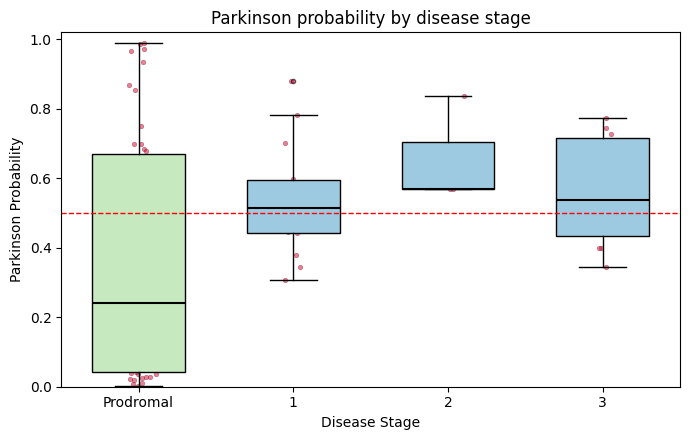

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv("../linear_regre_test_probs.csv")
df2 = pd.read_csv("../prodromal_probs.csv")

# Preparar datos H&Y
stages = sorted(df["stage"].unique())
data = [df[df["stage"] == s]["prob_parkinson"] for s in stages]

# Posición extra para prodromal (a la izquierda)
prodromal_pos = min(stages) - 1

fig, ax = plt.subplots(figsize=(7, 4.5))

# Boxplot H&Y
ax.boxplot(
    data,
    positions=stages,
    widths=0.6,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="#9ecae1", edgecolor="black", linewidth=1),
    medianprops=dict(color="black", linewidth=1.5),
    whiskerprops=dict(color="black", linewidth=1),
    capprops=dict(color="black", linewidth=1),
    flierprops=dict(
        marker="o",
        markersize=3,
        markerfacecolor="crimson",
        markeredgecolor="black",
        alpha=0.6
    ),
)

# Boxplot prodromal
ax.boxplot(
    df2["prob_parkinson"],
    positions=[prodromal_pos],
    widths=0.6,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="#c7e9c0", edgecolor="black", linewidth=1),
    medianprops=dict(color="black", linewidth=1.5),
    whiskerprops=dict(color="black", linewidth=1),
    capprops=dict(color="black", linewidth=1),
    flierprops=dict(
        marker="o",
        markersize=3,
        markerfacecolor="crimson",
        markeredgecolor="black",
        alpha=0.6
    ),
)

# Scatter H&Y
for s in stages:
    y = df[df["stage"] == s]["prob_parkinson"].values
    x = np.random.normal(s, 0.04, size=len(y))
    ax.scatter(
        x, y,
        s=12,
        c="crimson",
        alpha=0.55,
        edgecolors="black",
        linewidths=0.2
    )

# Scatter prodromal
y_prod = df2["prob_parkinson"].values
x_prod = np.random.normal(prodromal_pos, 0.04, size=len(y_prod))
ax.scatter(
    x_prod, y_prod,
    s=12,
    c="crimson",
    alpha=0.55,
    edgecolors="black",
    linewidths=0.2
)

# Línea horizontal de referencia
ax.axhline(0.5, color="red", linestyle="--", linewidth=1)

# Etiquetas y ticks
ax.set_xlabel("Disease Stage")
ax.set_ylabel("Parkinson Probability")
ax.set_title("Parkinson probability by disease stage")
ax.set_ylim(0, 1.02)

# Ticks personalizados
ax.set_xticks([prodromal_pos] + stages)
ax.set_xticklabels(["Prodromal"] + [str(s) for s in stages])

# Limpieza
ax.grid(False)
plt.tight_layout()
plt.show()


#### 12.3.1 Pruebas Mann-Whitney

In [3]:
import pandas as pd
from itertools import combinations
from scipy.stats import mannwhitneyu

df = pd.read_csv("../linear_regre_test_probs.csv")
df2 = pd.read_csv("../prodromal_probs.csv")

# Filtrar filas con stage y prob válidos
df = df.dropna(subset=["stage", "prob_parkinson"])
df2 = df2.dropna(subset=["prob_parkinson"])

# Asegurar orden numérico de los estadios
stages = sorted(df["stage"].unique())

results = []
for a, b in combinations(stages, 2):
    pa = df.loc[df["stage"] == a, "prob_parkinson"]
    pb = df.loc[df["stage"] == b, "prob_parkinson"]
    stat, p = mannwhitneyu(pa, pb, alternative="two-sided")
    results.append({"stage_a": a, "stage_b": b, "n_a": len(pa), "n_b": len(pb), "stat": stat, "p": p})

# Comparar prodromal con cada estadio
prodromal_probs = df2["prob_parkinson"]
for s in stages:
    stage_probs = df.loc[df["stage"] == s, "prob_parkinson"]
    stat, p = mannwhitneyu(prodromal_probs, stage_probs, alternative="two-sided")
    results.append({"stage_a": "prodromal", "stage_b": s, "n_a": len(prodromal_probs), "n_b": len(stage_probs), "stat": stat, "p": p})

res_df = pd.DataFrame(results)

# Corrección simple de Bonferroni
m = len(res_df)
res_df["p_bonf"] = res_df["p"] * m
res_df["p_bonf"] = res_df["p_bonf"].clip(upper=1.0)

# Mostrar resultados ordenados por p
display(res_df.sort_values("p"))

# Opcional: filtrar los pares significativos (p_bonf < 0.05)
display(res_df[res_df["p_bonf"] < 0.05])

,stage_a,stage_b,n_a,n_b,stat,p,p_bonf
5,prodromal,3,46,11,138.0,0.020597,0.123580
3,prodromal,1,46,14,195.0,0.027041,0.162248
4,prodromal,2,46,3,35.0,0.171624,1.000000
0,1,2,14,3,13.0,0.361765,1.000000
2,2,3,3,11,23.0,0.368132,1.000000
1,1,3,14,11,66.0,0.565412,1.000000


,stage_a,stage_b,n_a,n_b,stat,p,p_bonf


### 12.4 Visualización latente (PCA / t-SNE)

Model performance in the original feature space:
[test full-dim] acc=0.750 precision=0.684 recall=0.929 f1=0.788 auc=0.628 (tp=13, fp=6, fn=1, tn=8)
[test PCA2D] acc=0.429 precision=0.417 recall=0.357 f1=0.385 auc=0.464 (tp=5, fp=7, fn=9, tn=7)


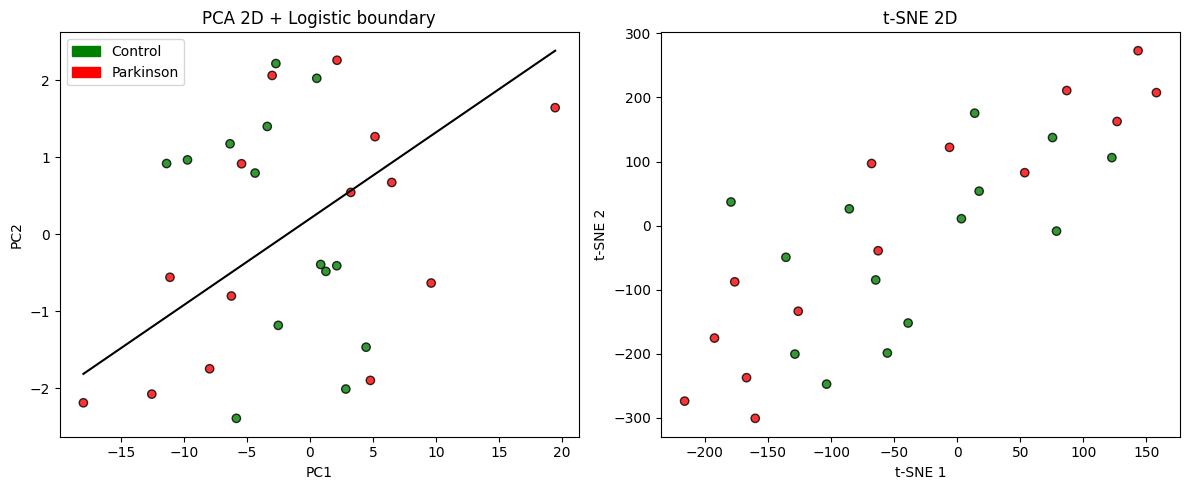

[test PCA3D] acc=0.500 precision=0.500 recall=0.500 f1=0.500 auc=0.500 (tp=7, fp=7, fn=7, tn=7)


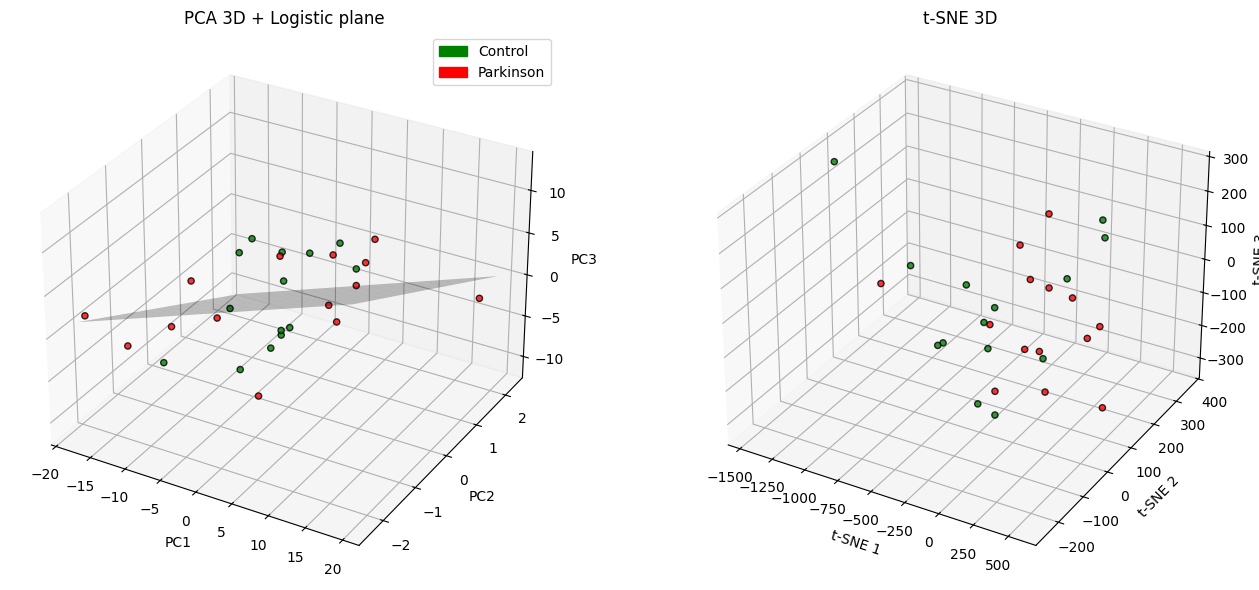

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa


ROOT = ".."  # raíz del repo; ajusta a "." si el notebook corre en la raíz
LATENT_ROOT = os.path.join(ROOT, "result/cond_unet_latents")
DATA_INFO = os.path.join(ROOT, "data_info/data_info.csv")

# --- utilidades básicas (extract_features + PCA + logística) ---
def extract_features(volume: np.ndarray) -> np.ndarray:
    vol = volume.astype(np.float32, copy=False)
    global_stats = np.array(
        [vol.mean(), vol.std(), vol.min(), vol.max(),
         np.median(vol), np.percentile(vol, 25), np.percentile(vol, 75)],
        dtype=np.float32,
    )
    axis0 = vol.mean(axis=(1, 2))
    axis1 = vol.mean(axis=(0, 2))
    axis2 = vol.mean(axis=(0, 1))
    return np.concatenate([global_stats, axis0, axis1, axis2]).astype(np.float32)

def load_latents(split, label_map=None):
    split_dir = os.path.join(LATENT_ROOT, split)
    feats, labels, ids = [], [], []
    for fname in sorted(os.listdir(split_dir)):
        if not fname.endswith(".npy"):
            continue
        sid = os.path.splitext(fname)[0]
        if label_map is not None and sid not in label_map:
            continue
        vol = np.load(os.path.join(split_dir, fname))
        feats.append(extract_features(vol))
        ids.append(sid)
        if label_map is not None:
            labels.append(label_map[sid])
    feats = np.vstack(feats).astype(np.float32)
    labels = np.array(labels, dtype=np.float32) if labels else np.array([], dtype=np.float32)
    return feats, labels, ids

def train_logistic(X, y, lr=0.05, epochs=500, l2=1e-3):
    w = np.zeros(X.shape[1], dtype=np.float32)
    b = 0.0
    for _ in range(epochs):
        z = X @ w + b
        p = 1 / (1 + np.exp(-z))
        err = p - y
        w -= lr * ((X.T @ err) / len(X) + l2 * w)
        b -= lr * err.mean()
    return w, b

def evaluate_binary(probs, y_true, name="test"):
    preds = (probs >= 0.5).astype(np.float32)
    acc = float((preds == y_true).mean())
    tp = float(((preds == 1) & (y_true == 1)).sum())
    tn = float(((preds == 0) & (y_true == 0)).sum())
    fp = float(((preds == 1) & (y_true == 0)).sum())
    fn = float(((preds == 0) & (y_true == 1)).sum())
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    n_pos, n_neg = (y_true == 1).sum(), (y_true == 0).sum()
    if n_pos > 0 and n_neg > 0:
        ranks = pd.Series(probs).rank(method="average").to_numpy()
        sum_pos = float(ranks[y_true == 1].sum())
        auc = (sum_pos - n_pos * (n_pos + 1) / 2.0) / (n_pos * n_neg)
    else:
        auc = float("nan")
    print(f"[{name}] acc={acc:.3f} precision={precision:.3f} recall={recall:.3f} "
          f"f1={f1:.3f} auc={auc:.3f} (tp={int(tp)}, fp={int(fp)}, fn={int(fn)}, tn={int(tn)})")

def pca_fit_transform(X, n_components):
    mu = X.mean(axis=0, keepdims=True)
    Xc = X - mu
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    comps = Vt[:n_components]
    return Xc @ comps.T, comps, mu

def pca_transform(X, comps, mu):
    return (X - mu) @ comps.T

# --- cargar datos ---
df_labels = pd.read_csv(DATA_INFO, dtype={"ID": str, "label": np.int32})
label_map = dict(zip(df_labels["ID"].astype(str), df_labels["label"].astype(int)))

X_train, y_train, _ = load_latents("train", label_map)
X_test, y_test, ids_test = load_latents("test", label_map)

# estandarizar
mu, sigma = X_train.mean(axis=0, keepdims=True), X_train.std(axis=0, keepdims=True)
sigma[sigma == 0] = 1.0
X_train_std = (X_train - mu) / sigma
X_test_std = (X_test - mu) / sigma

# Logística en el espacio original (features completas)
print("Model performance in the original feature space:")
w_full = np.zeros(X_train_std.shape[1], dtype=np.float32)
b_full = 0.0
lr, epochs, l2 = 0.05, 500, 1e-3

for _ in range(epochs):
    z = X_train_std @ w_full + b_full
    p = 1 / (1 + np.exp(-z))
    err = p - y_train
    w_full -= lr * ((X_train_std.T @ err) / len(X_train_std) + l2 * w_full)
    b_full -= lr * err.mean()

probs_full = 1 / (1 + np.exp(-(X_test_std @ w_full + b_full)))
evaluate_binary(probs_full, y_test, name="test full-dim")

# t-SNE 2D (visualización solamente)
tsne_2d = TSNE(n_components=2, perplexity=10, learning_rate=200, init="random", random_state=0)
Xte_tsne2 = tsne_2d.fit_transform(X_test_std)

# PCA 2D + logística
Xtr_2d, comps2, mu_pca2 = pca_fit_transform(X_train_std, 2)
Xte_2d = pca_transform(X_test_std, comps2, mu_pca2)
w2, b2 = train_logistic(Xtr_2d, y_train, lr=0.05, epochs=500, l2=1e-3)
probs_2d = 1 / (1 + np.exp(-(Xte_2d @ w2 + b2)))
evaluate_binary(probs_2d, y_test, name="test PCA2D")

fig, axes = plt.subplots(1, 2, figsize=(12,5))
colors = np.where(y_test==1, "red", "green")

# --- PCA 2D ---
axes[0].scatter(
    Xte_2d[:, 0], Xte_2d[:, 1],
    c=colors, edgecolor='k', alpha=0.8
)

# Frontera de decisión logística (solo PCA)
if w2[1] != 0:
    xs = np.linspace(Xte_2d[:, 0].min(), Xte_2d[:, 0].max(), 200)
    ys = -(w2[0] * xs + b2) / w2[1]
    axes[0].plot(xs, ys, 'k-', linewidth=1.5)

axes[0].set_title("PCA 2D + Logistic boundary")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# --- t-SNE 2D ---
axes[1].scatter(
    Xte_tsne2[:, 0], Xte_tsne2[:, 1],
    c=colors, edgecolor='k', alpha=0.8
)
axes[1].set_title("t-SNE 2D")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

# Leyenda común
ctrl_patch = mpatches.Patch(color="green", label="Control")
pd_patch   = mpatches.Patch(color="red", label="Parkinson")
axes[0].legend(handles=[ctrl_patch, pd_patch])

plt.tight_layout()
plt.show()

# t-SNE 3D (visualización solamente)
tsne_3d = TSNE(n_components=3, perplexity=10, learning_rate=200, init="random", random_state=0)
Xte_tsne3 = tsne_3d.fit_transform(X_test_std)

# PCA 3D + logística
Xtr_3d, comps3, mu_pca3 = pca_fit_transform(X_train_std, 3)
Xte_3d = pca_transform(X_test_std, comps3, mu_pca3)
w3, b3 = train_logistic(Xtr_3d, y_train, lr=0.05, epochs=500, l2=1e-3)
probs_3d = 1 / (1 + np.exp(-(Xte_3d @ w3 + b3)))
evaluate_binary(probs_3d, y_test, name="test PCA3D")

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(14,6))
ax_pca = fig.add_subplot(121, projection='3d')
ax_tsne = fig.add_subplot(122, projection='3d')

# --- PCA 3D ---
ax_pca.scatter(
    Xte_3d[:, 0], Xte_3d[:, 1], Xte_3d[:, 2],
    c=colors, edgecolor='k', alpha=0.8
)

# Plano de decisión logística
if w3[2] != 0:
    xg, yg = np.meshgrid(
        np.linspace(Xte_3d[:, 0].min(), Xte_3d[:, 0].max(), 15),
        np.linspace(Xte_3d[:, 1].min(), Xte_3d[:, 1].max(), 15)
    )
    zg = -(w3[0]*xg + w3[1]*yg + b3) / w3[2]
    ax_pca.plot_surface(xg, yg, zg, alpha=0.25, color='black')

ax_pca.set_title("PCA 3D + Logistic plane")
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")
ax_pca.set_zlabel("PC3")

# --- t-SNE 3D ---
ax_tsne.scatter(
    Xte_tsne3[:, 0], Xte_tsne3[:, 1], Xte_tsne3[:, 2],
    c=colors, edgecolor='k', alpha=0.8
)
ax_tsne.set_title("t-SNE 3D")
ax_tsne.set_xlabel("t-SNE 1")
ax_tsne.set_ylabel("t-SNE 2")
ax_tsne.set_zlabel("t-SNE 3")

# Leyenda común
ctrl_patch = mpatches.Patch(color="green", label="Control")
pd_patch   = mpatches.Patch(color="red", label="Parkinson")
ax_pca.legend(handles=[ctrl_patch, pd_patch])

plt.tight_layout()
plt.show()


#### 12.4.1 Visualización por estadios

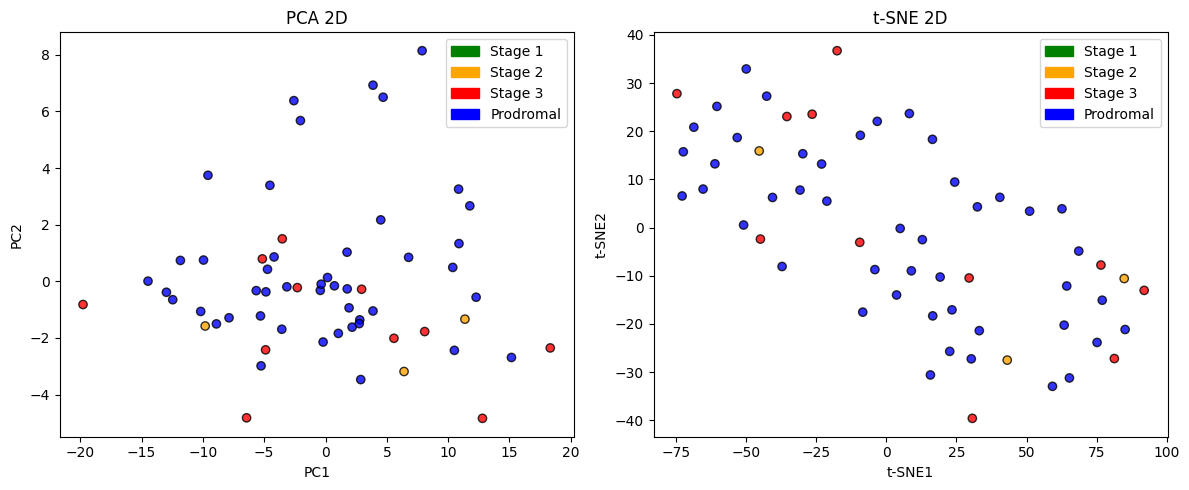

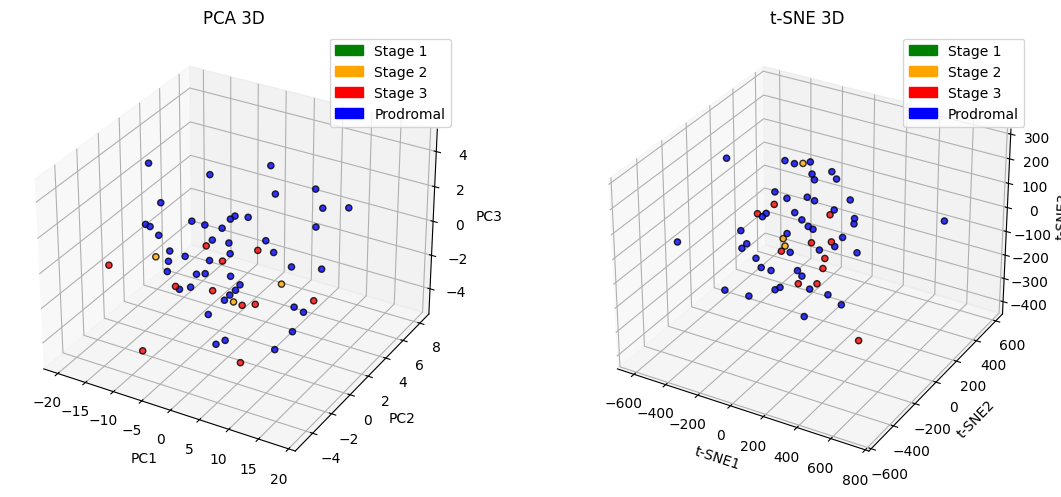

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = ".."  # usa "." si ejecutas desde la raíz
LATENT_ROOT = os.path.join(ROOT, "result/cond_unet_latents")
DATA_INFO = os.path.join(ROOT, "data_info/data_info.csv")
TEST_STAGE_CSV = os.path.join(ROOT, "linear_regre_test_probs.csv")
PRODROMAL_PROBS = os.path.join(ROOT, "prodromal_probs.csv")

# --- utils ---
def extract_features(vol: np.ndarray) -> np.ndarray:
    vol = vol.astype(np.float32, copy=False)
    global_stats = np.array(
        [vol.mean(), vol.std(), vol.min(), vol.max(),
         np.median(vol), np.percentile(vol, 25), np.percentile(vol, 75)],
        dtype=np.float32,
    )
    axis0 = vol.mean(axis=(1, 2))
    axis1 = vol.mean(axis=(0, 2))
    axis2 = vol.mean(axis=(0, 1))
    return np.concatenate([global_stats, axis0, axis1, axis2]).astype(np.float32)

def load_latents(split, ids_filter=None):
    split_dir = os.path.join(LATENT_ROOT, split)
    feats, ids = [], []
    for fname in sorted(os.listdir(split_dir)):
        if not fname.endswith(".npy"):
            continue
        sid = os.path.splitext(fname)[0]
        if ids_filter is not None and sid not in ids_filter:
            continue
        vol = np.load(os.path.join(split_dir, fname))
        feats.append(extract_features(vol))
        ids.append(sid)
    feats = np.vstack(feats).astype(np.float32) if feats else np.empty((0,0),dtype=np.float32)
    return feats, ids

# --- labels y stages ---
df_labels = pd.read_csv(DATA_INFO, dtype={"ID": str, "label": np.int32})
label_map = dict(zip(df_labels["ID"].astype(str), df_labels["label"].astype(int)))

stage_df = pd.read_csv(TEST_STAGE_CSV)
id_col = "PATNO" if "PATNO" in stage_df.columns else "id"
stage_map = dict(zip(stage_df[id_col].astype(str), stage_df["stage"]))

# IDs de test con label=1 (Parkinson) y stage 1/2/3
test_ids_pd = [i for i,l in label_map.items() if l==1 and i in stage_map and stage_map[i] in [1,2,3]]

# Cargar features
X_train, _ = load_latents("train")
X_test_pd, ids_test_pd = load_latents("test", ids_filter=test_ids_pd)
X_prod, ids_prod = load_latents("prodromal")

# Estandarizar con stats de train
mu, sigma = X_train.mean(axis=0, keepdims=True), X_train.std(axis=0, keepdims=True)
sigma[sigma==0] = 1.0
X_test_pd_std = (X_test_pd - mu) / sigma
X_prod_std = (X_prod - mu) / sigma

# Combinar para proyecciones
X_comb = np.vstack([X_test_pd_std, X_prod_std])
labels_comb = ["test_pd"]*len(ids_test_pd) + ["prodromal"]*len(ids_prod)
stages_comb = [stage_map[i] for i in ids_test_pd] + [None]*len(ids_prod)

# Colores por stage/prodromal
color_map_stage = {1:"green", 2:"orange", 3:"red"}
colors = [color_map_stage.get(s,"gray") if lbl=="test_pd" else "blue" for s,lbl in zip(stages_comb, labels_comb)]

# PCA
def pca_fit_transform(X, n_components):
    mu = X.mean(axis=0, keepdims=True)
    Xc = X - mu
    _, _, Vt = np.linalg.svd(Xc, full_matrices=False)
    comps = Vt[:n_components]
    return Xc @ comps.T, comps, mu

X_pca2, comps2, mu2 = pca_fit_transform(X_comb, 2)
X_pca3, comps3, mu3 = pca_fit_transform(X_comb, 3)

# t-SNE (requiere scikit-learn)
from sklearn.manifold import TSNE
tsne2 = TSNE(n_components=2, perplexity=10, learning_rate=200, init="random", random_state=0)
X_tsne2 = tsne2.fit_transform(X_comb)
tsne3 = TSNE(n_components=3, perplexity=10, learning_rate=200, init="random", random_state=0)
X_tsne3 = tsne3.fit_transform(X_comb)

# Leyenda
patches = [
    plt.matplotlib.patches.Patch(color="green", label="Stage 1"),
    plt.matplotlib.patches.Patch(color="orange", label="Stage 2"),
    plt.matplotlib.patches.Patch(color="red", label="Stage 3"),
    plt.matplotlib.patches.Patch(color="blue", label="Prodromal"),
]

# Plots 2D: PCA vs t-SNE
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].scatter(X_pca2[:,0], X_pca2[:,1], c=colors, edgecolor='k', alpha=0.8)
axes[0].set_title("PCA 2D"); axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")
axes[1].scatter(X_tsne2[:,0], X_tsne2[:,1], c=colors, edgecolor='k', alpha=0.8)
axes[1].set_title("t-SNE 2D"); axes[1].set_xlabel("t-SNE1"); axes[1].set_ylabel("t-SNE2")
for ax in axes:
    ax.legend(handles=patches)
plt.tight_layout(); plt.show()

# Plots 3D: PCA vs t-SNE
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(12,5))
ax_pca3 = fig.add_subplot(121, projection='3d')
ax_tsne3 = fig.add_subplot(122, projection='3d')
ax_pca3.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2], c=colors, edgecolor='k', alpha=0.8)
ax_pca3.set_title("PCA 3D"); ax_pca3.set_xlabel("PC1"); ax_pca3.set_ylabel("PC2"); ax_pca3.set_zlabel("PC3")
ax_tsne3.scatter(X_tsne3[:,0], X_tsne3[:,1], X_tsne3[:,2], c=colors, edgecolor='k', alpha=0.8)
ax_tsne3.set_title("t-SNE 3D"); ax_tsne3.set_xlabel("t-SNE1"); ax_tsne3.set_ylabel("t-SNE2"); ax_tsne3.set_zlabel("t-SNE3")
for ax in (ax_pca3, ax_tsne3):
    ax.legend(handles=patches)
plt.tight_layout(); plt.show()
